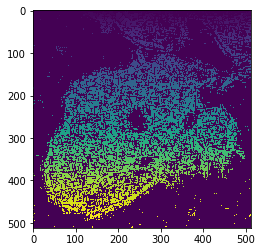

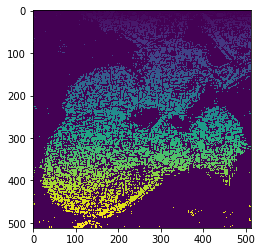

KeyboardInterrupt: 

In [16]:
### Trying different methods to segment the DIC-C2DH-HeLa dataset ###
### The chosen cv2 method should work on all the datasets ###
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.segmentation import active_contour

cap = cv2.VideoCapture("Sequences/DIC-C2DH-HeLa/Sequence 1/t%03d.tif", cv2.CAP_IMAGES)
old = np.ones((512, 512))

while cap.isOpened():
    ret, frame = cap.read()
    
    ### Motion detection through subtraction of old frame from the new frame ###
    ### Does not work when background and foreground are so close to eqach other ###
    subtract = frame - old
    
    ### Gray conversion ###
    #gray = frame.convert('L')
    #rgb_weights = [0.2989, 0.5870, 0.1140]
    #gray = np.dot(frame[...,:3], rgb_weights)
    #img_array = np.array(gray)
    
    ### Edges of a gray scale image - does not work for cell segmentation ###
    #edges = cv2.Canny(blur,100,200)
    
    ### Kernel for morphological tranformation ###
    kernel = np.ones((5,5),np.uint8)
    
    ### Adaptive histogram equalization of a gray scale image - amplifies the contrast of the image ###
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(frame)
    #cl = frame ## IF CLAHE FILTER IS NOT APPLIED ##
    
    ### Blurring to smooth the insides of the cells ###
    ### Choose the appropriate blur ###
    #cl = cv2.GaussianBlur(frame,(9,9),0)
    cl = cv2.bilateralFilter(frame,9,75,75)
    cl = cv2.medianBlur(frame, 11)
    
    ### H-dome filter for gray scale images ###
    R0 = cl - 25
    Ri = R0
    
    while True:
        Rold = Ri
        dilate = cv2.dilate(Rold,kernel,iterations = 1)
        Ri = (np.minimum(dilate,  cl))
        if Ri.all() == Rold.all():
            break
    Dh = cl - Ri
    #Dh = frame ## IF H-DOME FILTERING IS NOT APPLIED ##
    
    ### Applying the proper threshold to the h-dome image to obtain a binary image ###
    ### Choose the appropriate threshold function ###
    #thresh = cv2.adaptiveThreshold(Dh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    #thresh = cv2.threshold(Dh, 0, 255, cv2.THRESH_OTSU)[1]
    #thresh = cv2.threshold(Dh, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.threshold(Dh,23,255,cv2.THRESH_BINARY)[1]
    thresh = cv2.bitwise_not(thresh)
    #thresh = frame ## IF NO THRESHOLDING IS APPLIED ##
    
    ### Laplacian transform to obtain binary image ###
    #dst = cv2.Laplacian(thresh, cv2.CV_16S, ksize=3)
    #dst = cv2.convertScaleAbs(dst)
    
    ### Binary image manipulation to remove artifacts ###
    #erosion = cv2.erode(thresh,kernel,iterations = 5)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    #edges = cv2.Canny(Dh,100,200)
    #final = frame - closing
    
    
    ### WATERSHED SEGMENTATION of the final binary image ###
    distance = ndi.distance_transform_edt(thresh)

    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)),
                            labels=thresh)
    markers = ndi.label(local_maxi)[0]

    ws_labels = watershed(-distance, markers, mask=thresh, watershed_line=True)
    
    
    ### Find the contours on the segmented image ###
    #image, contours, hierarchy = cv2.findContours(ws_labels, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #img = cv2.drawContours(frame, contours, -1, (0,0,0), 3)
    
    ### Plotting the obtained results ##
    fig = plt.figure()
    #fig, ax = plt.subplots(figsize=(7, 7))
    #fig.add_subplot(1, 2, 1)
    #plt.imshow(frame, cmap=plt.get_cmap("gray"))
    #fig.add_subplot(1, 2, 2)
    plt.imshow(ws_labels)#, cmap=plt.get_cmap("gray"))
    plt.show()
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    old = frame